In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [59]:
# load images and labels Old

from collections import Counter

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]


numImages = len(imageFileNames)

classWeights = {
	'label': dict([(i, (1 / labelDict[labelTuple[i]]) * (numImages / 2.0)) for i in range(len(labelTuple))]),
	'cell_shape': dict([(i, (1 / cellShapeDict[cellShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(cellShapeTuple))]),
	'nucleus_shape': dict([(i, (1 / nucleusShapeDict[nucleusShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(nucleusShapeTuple))]),
	'cytoplasm_vacuole': dict([(i, (1 / cytoplasmVacuoleDict[cytoplasmVacuoleTuple[i]]) * (numImages / 2.0)) for i in range(len(cytoplasmVacuoleTuple))])
}

classRandomAcc = {
	'label': sum([(i / numImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(classWeights)
print(classRandomAcc)

print(f'label: {[f"{key}: {value / 50}" for key, value in labelDict.items()]} | {100 / len(labelDict)}')
print(f'cell shape: {[f"{key}: {value / 50}" for key, value in cellShapeDict.items()]} | {100 / len(cellShapeDict)}')
print(f'nuclius shape: {[f"{key}: {value / 50}" for key, value in nucleusShapeDict.items()]} | {100 / len(nucleusShapeDict)}')
print(f'cytoplasm vacuole: {[f"{key}: {value / 50}" for key, value in cytoplasmVacuoleDict.items()]} | {100 / len(cytoplasmVacuoleDict)}')
# print(allLabelDict)

{'label': {0: 4.317789291882556, 1: 3.681885125184094, 2: 3.980891719745223, 3: 1.5527950310559007, 4: 1.6622340425531914}, 'cell_shape': {0: 0.6403688524590164, 1: 2.281021897810219}, 'nucleus_shape': {0: 4.844961240310077, 1: 3.852080123266564, 2: 5.827505827505828, 3: 3.993610223642172, 4: 1.937984496124031, 5: 1.6778523489932884}, 'cytoplasm_vacuole': {0: 0.5389092476826902, 1: 6.925207756232687}}
{'label': 0.24179128, 'cellShape': 0.65769728, 'nucleusShape': 0.20590296, 'cytoplasmVacuole': 0.8660256799999999}
label: ['Lymphocyte: 11.58', 'Monocyte: 13.58', 'Basophil: 12.56', 'Neutrophil: 32.2', 'Eosinophil: 30.08'] | 20.0
cell shape: ['round: 78.08', 'irregular: 21.92'] | 50.0
nuclius shape: ['unsegmented-round: 10.32', 'unsegmented-indented: 12.98', 'irregular: 8.58', 'segmented-multilobed: 12.52', 'unsegmented-band: 25.8', 'segmented-bilobed: 29.8'] | 16.666666666666668
cytoplasm vacuole: ['no: 92.78', 'yes: 7.22'] | 50.0


In [68]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	key = os.path.basename(path)[:9]
	
	if key not in allLabelDict:
		print("Missing key:", key)
		raise ValueError("Missing label key.")
	return tf.convert_to_tensor(allLabelDict[key])

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	return img, labelDict

def augment(img, label):
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_flip_left_right(img)

    return img, label


valSize = int(imageFileNames.cardinality().numpy() * 0.2)

trainData = imageFileNames \
  .skip(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 
	
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

print(tf.data.experimental.cardinality(trainData).numpy())
print(tf.data.experimental.cardinality(valData).numpy())


400
100


In [113]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))
inputRescale = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputLayer)

# imagenet pre made model
baseModel = tf.keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(360, 360, 3),
    include_top=False
)
baseModel.trainable = False
convoLayers = baseModel(inputRescale, training=False)

# custom convo layers
# convoLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputRescale)
# convoLayers = tf.keras.layers.MaxPooling2D()(convoLayers)
# convoLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(convoLayers)
# convoLayers = tf.keras.layers.MaxPooling2D()(convoLayers)
# convoLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(convoLayers)

# universal model layers
baseLayers = tf.keras.layers.MaxPooling2D()(convoLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)

#label 
labelOutput = tf.keras.layers.Dense(len(labelTuple), name='labelOutput')(baseLayers)

# cell shape
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), name='cellShapeOutput')(baseLayers)

# nucleus shape
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), name='nucleusShapeOutput')(baseLayers)

# cytoplasm vacuole
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), name='cytoplasmVacuoleOutput')(baseLayers)

model = tf.keras.Model(
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'cellShapeOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'nucleusShapeOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'cytoplasmVacuoleOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	},
  metrics={
		'labelOutput': 'accuracy',
		'cellShapeOutput': 'accuracy',
		'nucleusShapeOutput': 'accuracy',
		'cytoplasmVacuoleOutput': 'accuracy'
	},
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_21        │ (None, 360, 360,  │          0 │ input_layer_27[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 11, 11,    │ 14,714,688 │ rescaling_21[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 5, 5, 512) │          0 │ vgg16[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12800)     │          0 │ max_pooling2d_43… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │    819,264 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      4,160 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      4,160 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │        130 │ dense_43[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │        130 │ dense_43[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        325 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        390 │ dense_43[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,543,247 (59.29 MB)

 Trainable params: 828,559 (3.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [57]:
# clean 

for layer in model.layers:
	if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
		layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
	if hasattr(layer, 'bias_initializer') and hasattr(layer, 'bias'):
		layer.bias.assign(layer.bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

tf.keras.backend.clear_session(free_memory=True)


2025-08-21 18:32:24.726867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-21 18:32:24.729278: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [114]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=8,
  batch_size=10
)


Epoch 1/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - cellShapeOutput_accuracy: 0.8375 - cellShapeOutput_loss: 0.3627 - cytoplasmVacuoleOutput_accuracy: 0.9380 - cytoplasmVacuoleOutput_loss: 0.1830 - labelOutput_accuracy: 0.8043 - labelOutput_loss: 0.5266 - loss: 2.2250 - nucleusShapeOutput_accuracy: 0.5360 - nucleusShapeOutput_loss: 1.1527 - val_cellShapeOutput_accuracy: 0.8960 - val_cellShapeOutput_loss: 0.2614 - val_cytoplasmVacuoleOutput_accuracy: 0.9530 - val_cytoplasmVacuoleOutput_loss: 0.1357 - val_labelOutput_accuracy: 0.9330 - val_labelOutput_loss: 0.2120 - val_loss: 1.6445 - val_nucleusShapeOutput_accuracy: 0.6020 - val_nucleusShapeOutput_loss: 1.0354
Epoch 2/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - cellShapeOutput_accuracy: 0.8890 - cellShapeOutput_loss: 0.2670 - cytoplasmVacuoleOutput_accuracy: 0.9585 - cytoplasmVacuoleOutput_loss: 0.1321 - labelOutput_accuracy: 0.9450 - labelOutput_loss: 0.1615 - loss: 1.4650 - nucleusShapeOutput_accuracy: 0.6457 - nucleusShapeOutpu

label 0.9419999718666077
cellShape 0.8759999871253967
nucleusShape 0.6230000257492065
cytoplasmVacuole 0.9570000171661377


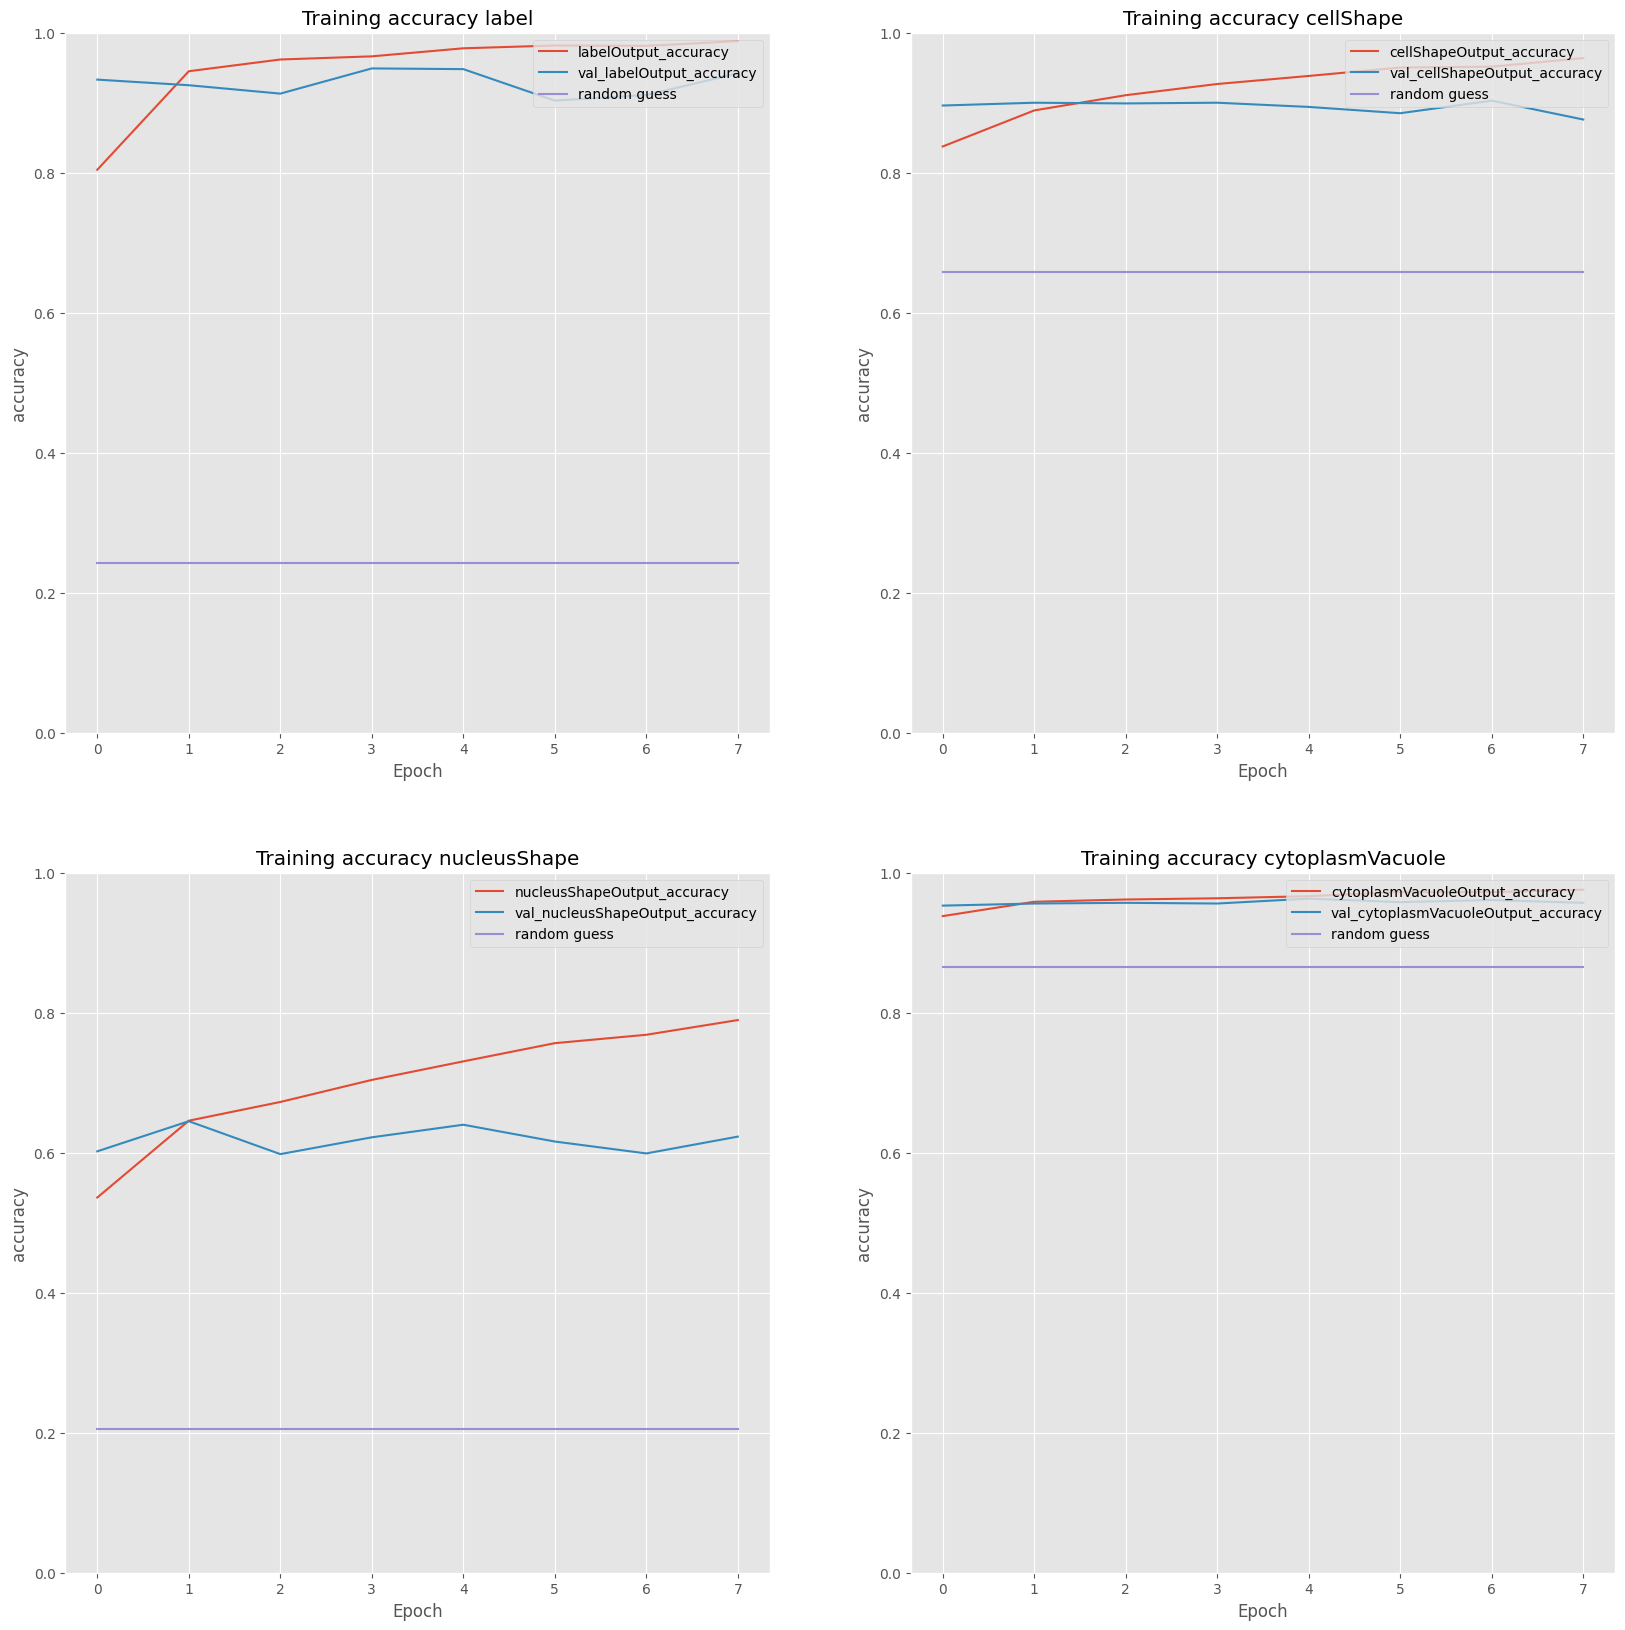

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - cellShapeOutput_accuracy: 0.8760 - cellShapeOutput_loss: 0.3521 - cytoplasmVacuoleOutput_accuracy: 0.9570 - cytoplasmVacuoleOutput_loss: 0.1364 - labelOutput_accuracy: 0.9420 - labelOutput_loss: 0.1951 - loss: 1.7111 - nucleusShapeOutput_accuracy: 0.6230 - nucleusShapeOutput_loss: 1.0275


{'cellShapeOutput_accuracy': 0.8759999871253967,
 'cellShapeOutput_loss': 0.35209327936172485,
 'cytoplasmVacuoleOutput_accuracy': 0.9570000171661377,
 'cytoplasmVacuoleOutput_loss': 0.1363653987646103,
 'labelOutput_accuracy': 0.9419999718666077,
 'labelOutput_loss': 0.19512496888637543,
 'loss': 1.711065649986267,
 'nucleusShapeOutput_accuracy': 0.6230000257492065,
 'nucleusShapeOutput_loss': 1.0274821519851685}

In [ ]:
# plot

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

i = 0
for outLabel in ['label', 'cellShape', 'nucleusShape', 'cytoplasmVacuole']:
	i += 1
	plt.subplot(2,2,i)
	trainKey = f'{outLabel}Output_accuracy'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [classRandomAcc[outLabel] for i in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {outLabel}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="upper right") 

	print(f'{outLabel} {history.history[testKey][-1]}')

plt.show()

model.evaluate(valData, return_dict=True)

# label 0.9419999718666077
# cellShape 0.8759999871253967
# nucleusShape 0.6230000257492065
# cytoplasmVacuole 0.9570000171661377